# DeepEurovoc

The aim of this little experiment is to predict Eurovoc categories of publications based on expression abstracts published by the PO. 

The model used in this notebook is based on the 1D CNN described in the Keras blog article https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html. It uses pre-trained GloVe word embeddings for text classification.

The input data is retrieved from the public SPARQL endpoint of the PO which is available at http://publications.europa.eu/webapi/rdf/sparql. The following query does the job:

The input data has already been downloaded and is stored in data.csv. Before loading the data, the modules needed throughout this notebook are imported.

In [45]:
import pandas as pd
import numpy as np
import os
import sys
import xml.etree.ElementTree as ET
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.initializers import Constant
from keras.layers import Dropout

from sklearn.preprocessing import MultiLabelBinarizer

import matplotlib.pyplot as plt

Definition of some global variables used in this notebook:

In [46]:
CLEANUP_DATA = False # save time by loading a cleaned up version from disc
MAX_NUM_WORDS = 20000 # max. size of vocabulary
EMBEDDING_DIM = 100 # dimension of GloVe word embeddings
MAX_SEQUENCE_LENGTH = 1000 # truncate examples after MAX_SEQUENCE_LENGTH words
VALIDATION_SPLIT = 0.2 # ration for split of training data and test data
NUM_EPOCHS = 1 # number of epochs the network is trained

Load the data and get some numbers...

In [47]:
data_df = pd.read_csv("data.csv")
print(data_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35472 entries, 0 to 35471
Data columns (total 3 columns):
exp         35472 non-null object
abstract    35472 non-null object
concepts    35472 non-null object
dtypes: object(3)
memory usage: 831.5+ KB
None


We define a function that will help us to extract the abstracts as plain text from the XMLLiterals returned by Virtuoso, to remove all non-English words including stop words, and to perform lemmatization on the filtered words.

In [48]:
def cleanup_abstract(xmlstring):
    #import ipdb; ipdb.set_trace()
    xmlstring = xmlstring.replace('""', '"')
    text = None
    try: 
        tree = ET.ElementTree(ET.fromstring(xmlstring))
        xpath_result = tree.findall(".//description")
        text = xpath_result[0].text
    except:
        text = xmlstring
    # remove stopwords and punctuation. lower case everything
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    tokens = [w.lower() for w in tokens if not w in stop_words and w.isalpha() and wordnet.synsets(w)]
    # lemmatize
    lemma = WordNetLemmatizer()
    final_tokens = []
    for word in tokens:
        final_tokens.append(lemma.lemmatize(word))
    ret = " ".join(final_tokens)
    return ret

Cleaning the data involves two steps:

1\. processing of the abstracts 

2\. transform the ";" separated eurovoc codes in the concepts column into lists of eurovoc categories. Only consider to first two digits of the eurovoc codes. The total number of codes  in the data set is much too high (>5000) for classification. Therefore, the first two digits indication the "subject matter" are extracted.

In [49]:
if CLEANUP_DATA:
    data_df["clean_abstract"] = data_df["abstract"].apply(cleanup_abstract)
    data_df["clean_concepts"] = data_df["concepts"].apply(lambda x: list({c[c.rfind("/")+1:c.rfind("/")+3] for c in x.split(";")}))
    #concepts_list = data_df["concepts"].tolist()
    data_df.drop(["abstract"], axis=1)
    data_df.to_pickle("data_df.pkl")

The next line loads the cleaned up data directly from file instead of computing it everytime the notebook is executed.

In [50]:
data_df = pd.read_pickle("data_df.pkl")
print(data_df['clean_abstract'][:5])
print(data_df['clean_concepts'][:5])

0    at institute reference material measurement di...
1    statistic focus describes preliminary result b...
2    short document aim provide summary main issue ...
3    briefing note intended provide european parlia...
4    exterior de la sus la de para de en la en para...
Name: clean_abstract, dtype: object
0            [34, 25, 53, 11, 40, 37]
1                        [42, 46, 63]
2    [17, 52, 43, 53, 19, 44, 24, 18]
3        [52, 11, 10, 44, 13, 36, 93]
4             [14, 42, 13, 9, 31, 27]
Name: clean_concepts, dtype: object


We must convert the data set labels to numbers so that they can be processed by Keras. The approach is described in https://www.pyimagesearch.com/2018/05/07/multi-label-classification-with-keras/.

In [51]:
labels = data_df["clean_concepts"].tolist()
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(labels)
# loop over each of the possible class labels and show them
for (i, label) in enumerate(mlb.classes_):
	print("{}. {}".format(i + 1, label))

1. 10
2. 11
3. 12
4. 13
5. 14
6. 15
7. 16
8. 17
9. 18
10. 19
11. 20
12. 21
13. 22
14. 23
15. 24
16. 25
17. 26
18. 27
19. 28
20. 29
21. 3
22. 30
23. 31
24. 32
25. 33
26. 34
27. 35
28. 36
29. 37
30. 38
31. 39
32. 40
33. 41
34. 42
35. 43
36. 44
37. 45
38. 46
39. 47
40. 48
41. 49
42. 5
43. 50
44. 51
45. 52
46. 53
47. 54
48. 55
49. 56
50. 57
51. 58
52. 59
53. 6
54. 60
55. 61
56. 62
57. 63
58. 64
59. 65
60. 66
61. 67
62. 68
63. 69
64. 7
65. 70
66. 71
67. 72
68. 73
69. 74
70. 75
71. 76
72. 77
73. 78
74. 79
75. 8
76. 80
77. 81
78. 82
79. 83
80. 84
81. 85
82. 86
83. 87
84. 88
85. 89
86. 9
87. 90
88. 91
89. 92
90. 93
91. 94
92. 95
93. 96
94. 97
95. 98
96. 99


A small test to make sure that MultiLabelBinarizer is really generating multi-label vectors and not just one-hot vectors.

In [52]:
print("Labels of the 2nd training example: " + str(mlb.inverse_transform(np.array([labels[1]]))))

Labels of the 2nd training example: [('42', '46', '63')]


Next we need to tranform the input examples into an array of numbers:

In [53]:
data = data_df["clean_abstract"].tolist()

#print(len(data[0]))
#print(type(data[0]))
#print(data[0])
tokenizer = Tokenizer(nb_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(data)
sequences = tokenizer.texts_to_sequences(data)

#print(len(sequences[0]))
#print(sequences[0])

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
#labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)


/Users/sebastianthelen/anaconda3/lib/python3.6/site-packages/keras/preprocessing/text.py:172: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Found 22343 unique tokens.
Shape of data tensor: (35472, 1000)
Shape of label tensor: (35472, 96)


Split data into training data and test data.

In [54]:
# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
num_validation_samples = int(VALIDATION_SPLIT * data.shape[0])
print(num_validation_samples)
trainX = data[:-num_validation_samples]
trainY = labels[:-num_validation_samples]
testX = data[-num_validation_samples:]
testY = labels[-num_validation_samples:]

print("trainX.shape", trainX.shape)
print("trainY.shape", trainY.shape)
print("testX.shape", testX.shape)
print("testY.shape", testY.shape)

7094
trainX.shape (28378, 1000)
trainY.shape (28378, 96)
testX.shape (7094, 1000)
testY.shape (7094, 96)


Load the pre-computed GloVe word embeddings from file and create an embeddings_index:

In [55]:
embeddings_index = {}
with open(os.path.join('glove.6B', 'glove.6B.100d.txt'), 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


Use word_index and embedding_index to compute the embedding_matrix. embedding_matrix is  a matrix storing the embedded_vector for each word in the data set. 

In [56]:
num_words = min(MAX_NUM_WORDS, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    #else:
    #    print("Not not in embedding index: " + word)

Build an Keras embedding_layer. Note that trainable=false, i.e., weights are not getting updated. 

In [57]:
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

Let's define the 1D convolutional model.

In [58]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Dropout(0.25)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Dropout(0.25)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(35)(x)  # global max pooling
x = Dropout(0.25)(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(labels.shape[1], activation='sigmoid')(x)

model = Model(sequence_input, preds)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['categorical_accuracy'])

Now the model needs to be trained.

In [59]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 1000, 100)         2000000   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 996, 128)          64128     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 199, 128)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 199, 128)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 195, 128)          82048     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 39, 128)           0         
__________

In [60]:
history = model.fit(trainX, trainY, validation_data=(testX, testY),
          epochs=NUM_EPOCHS, batch_size=128)


Train on 28378 samples, validate on 7094 samples
Epoch 1/1
28378/28378 [==============================] - 295s 10ms/step - loss: 0.2388 - categorical_accuracy: 0.0666 - val_loss: 0.2129 - val_categorical_accuracy: 0.0710


Save the model to disc!

In [61]:
model.save("model.h5")

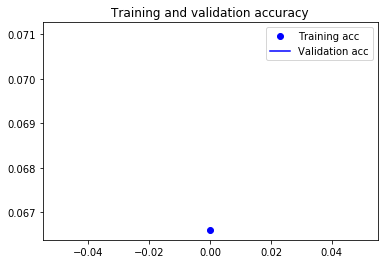

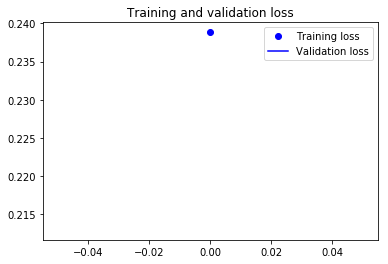

In [62]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Predict using an example from the training set. Later we should also create a dev set for prediction.

In [63]:
ex = data_df['clean_abstract'][0]
seq = tokenizer.texts_to_sequences(ex)
seq = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
print("ex = ", ex)
print("len(ex) = ", len(ex))
print("seq.shape = ", seq.shape)
print("Example: " + str(ex) + "\n")
print("Sequence: " + str(seq) + "\n")
prediction = model.predict(np.array(seq))[0]
prediction[prediction>=0.5] = 1
prediction[prediction<0.5] = 0
print("Prediction: " + str(prediction))
print("type(prediction) = ", type(prediction))
print("prediction.shape = ", prediction.shape)

mlb.inverse_transform(np.array([prediction]))

#proba = model.predict(np.array(seq))[0]
#idxs = np.argsort(proba)[::-1][:2]



ex =  at institute reference material measurement dismantling campaign obsolete installation glove box run main goal create le waste possible extensive contamination check decontaminating necessary glove box decontamination possible here necessary document stage dismantling process purpose report learn experience campaign gave ability make estimate future radioactive waste classic waste expected dismantled installation
len(ex) =  416
seq.shape =  (416, 1000)
Example: at institute reference material measurement dismantling campaign obsolete installation glove box run main goal create le waste possible extensive contamination check decontaminating necessary glove box decontamination possible here necessary document stage dismantling process purpose report learn experience campaign gave ability make estimate future radioactive waste classic waste expected dismantled installation

Sequence: [[   0    0    0 ...    0    0   32]
 [   0    0    0 ...    0    0 1891]
 [   0    0    0 ...    0 

[()]